In [1]:
# spacy2.1.0
# python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
# Uninstalling using:
# pip uninstall neuralcoref,
# reinstalling using:
# pip install neuralcoref --no-binary neuralcoref
# then restarting the entire kernel

In [3]:
# Step 1: Coreference resolution
# find all expressions in the text that refer to a specific entity
# Neuralcoref model from Huggingface 
# SpaCy
import spacy
import neuralcoref


# Load SpaCy
# nlp = spacy.load('en')
# Add neural coref to SpaCy's pipe
neuralcoref.add_to_pipe(nlp)

def coref_resolution(text):
    """Function that executes coreference resolution on a given text"""
    doc = nlp(text)
    # fetches tokens with whitespaces from spacy document
    tok_list = list(token.text_with_ws for token in doc)
    for cluster in doc._.coref_clusters:
        # get tokens from representative cluster name
        cluster_main_words = set(cluster.main.text.split(' '))
#         print("debug")
        for coref in cluster:
            if coref != cluster.main:  # if coreference element is not the representative element of that cluster
                if coref.text != cluster.main.text and bool(set(coref.text.split(' ')).intersection(cluster_main_words)) == False:
                    # if coreference element text and representative element text are not equal and none of the coreference element words are in representative element. This was done to handle nested coreference scenarios
                    tok_list[coref.start] = cluster.main.text + \
                        doc[coref.end-1].whitespace_
                    for i in range(coref.start+1, coref.end):
                        tok_list[i] = ""

    return "".join(tok_list)

In [4]:
# example text: “He” to “Elon Musk”
example_text = "Elon Musk is a business magnate, industrial designer, and engineer. He is the founder, CEO, CTO, and chief designer of SpaceX. He is also early investor, CEO, and product architect of Tesla, Inc. He is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. He briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. He transferred to the University of Pennsylvania two years later, where he received dual bachelor's degrees in economics and physics. He moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. He went on co-founding a web software company Zip2 with his brother Kimbal Musk."
example_text

"Elon Musk is a business magnate, industrial designer, and engineer. He is the founder, CEO, CTO, and chief designer of SpaceX. He is also early investor, CEO, and product architect of Tesla, Inc. He is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. He briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. He transferred to the University of Pennsylvania two years later, where he received dual bachelor's degrees in economics and physics. He moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. He went on co-founding a web software company Zip2 with his brother Kimbal Musk."

In [5]:
# text after coreference resolution
coref_text = coref_resolution(example_text)
coref_text

"Elon Musk is a business magnate, industrial designer, and engineer. Elon Musk is the founder, CEO, CTO, and chief designer of SpaceX. Elon Musk is also early investor, CEO, and product architect of Tesla, Inc. Elon Musk is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. Elon Musk briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. Elon Musk transferred to the University of Pennsylvania two years later, where Elon Musk received dual bachelor's degrees in economics and physics. Elon Musk moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. Elon Musk went on co-founding a web software company Zip2 with 

In [6]:
# Step 2: Named Entity Linking
# using Named Entity Linking to construct a knowledge graph
# Facebook BLINK 32GB ram required
# so switch to old good Wikifier API
# split the text into sentences and remove the punctuations
import urllib
from string import punctuation
import nltk
import json
ENTITY_TYPES = ["human", "person", "company", "enterprise", "business", "geographic region",
                "human settlement", "geographic entity", "territorial entity type", "organization"]

def wikifier(text, lang="en", threshold=0.8):
    """Function that fetches entity linking results from wikifier.com API"""
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "tgbdmkpmkluegqfbawcwjywieevmza"),
        ("pageRankSqThreshold", "%g" %
         threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "100"), ("nWordsToIgnoreFromList", "100"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
    ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout=60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    results = list()
    for annotation in response["annotations"]:
        # Filter out desired entity classes
        if ('wikiDataClasses' in annotation) and (any([el['enLabel'] in ENTITY_TYPES for el in annotation['wikiDataClasses']])):

            # Specify entity label
            if any([el['enLabel'] in ["human", "person"] for el in annotation['wikiDataClasses']]):
                label = 'Person'
            elif any([el['enLabel'] in ["company", "enterprise", "business", "organization"] for el in annotation['wikiDataClasses']]):
                label = 'Organization'
            elif any([el['enLabel'] in ["geographic region", "human settlement", "geographic entity", "territorial entity type"] for el in annotation['wikiDataClasses']]):
                label = 'Location'
            else:
                label = None

            results.append({'title': annotation['title'], 'wikiId': annotation['wikiDataItemId'], 'label': label,
                            'characters': [(el['chFrom'], el['chTo']) for el in annotation['support']]})
    return results

In [7]:
entities = wikifier(coref_text)
entities

[{'title': 'Elon Musk',
  'wikiId': 'Q317521',
  'label': 'Person',
  'characters': [(0, 8),
   (5, 8),
   (68, 76),
   (73, 76),
   (134, 142),
   (139, 142),
   (210, 218),
   (215, 218),
   (315, 318),
   (456, 459),
   (554, 562),
   (559, 562),
   (670, 678),
   (675, 678),
   (749, 757),
   (754, 757),
   (818, 826),
   (823, 826),
   (936, 944),
   (941, 944),
   (999, 1007),
   (1004, 1007),
   (1024, 1027)]},
 {'title': 'SpaceX',
  'wikiId': 'Q193701',
  'label': 'Organization',
  'characters': [(126, 131)]},
 {'title': 'Tesla, Inc.',
  'wikiId': 'Q478214',
  'label': 'Organization',
  'characters': [(198, 202), (198, 207), (198, 208)]},
 {'title': 'The Boring Company',
  'wikiId': 'Q28874479',
  'label': 'Organization',
  'characters': [(243, 260), (247, 260)]},
 {'title': 'Neuralink',
  'wikiId': 'Q29043471',
  'label': 'Organization',
  'characters': [(284, 292)]},
 {'title': 'Jeff Bezos',
  'wikiId': 'Q312556',
  'label': 'Person',
  'characters': [(444, 453), (449, 453)]}

In [8]:
import pandas as pd
pd.DataFrame(entities)

,title,wikiId,label,characters
0,Elon Musk,Q317521,Person,"[(0, 8), (5, 8), (68, 76), (73, 76), (134, 142..."
1,SpaceX,Q193701,Organization,"[(126, 131)]"
2,"Tesla, Inc.",Q478214,Organization,"[(198, 202), (198, 207), (198, 208)]"
3,The Boring Company,Q28874479,Organization,"[(243, 260), (247, 260)]"
4,Neuralink,Q29043471,Organization,"[(284, 292)]"
5,Jeff Bezos,Q312556,Person,"[(444, 453), (449, 453)]"
6,South Africa,Q258,Organization,"[(495, 507), (540, 551)]"
7,Pretoria,Q3926,Organization,"[(530, 537), (530, 551), (599, 606)]"
8,University of Pretoria,Q604444,Organization,"[(585, 606)]"
9,University of Pennsylvania,Q49117,Organization,"[(695, 724), (699, 724), (713, 724)]"


In [9]:
# pip3 install --upgrade pip setuptools
# https://github.com/thunlp/OpenNRE/issues/217

In [10]:
# Step 3: Relationship extraction
# Name Entity Recognition NER
# OpenNRE project； only infers relationships and doesn’t try to extract named entities
# https://github.com/thunlp/OpenNRE

# five open-source relationship extraction models that were trained on either the Wiki80 or Tacred dataset
# Wiki80 dataset is used
# wiki80_bert_softmax model (BERT encoder used)
# Iterate over every permutation pair of entities
import itertools
import opennre
relation_model = opennre.get_model('wiki80_bert_softmax')
relations_list = []



2021-11-02 11:45:37,544 - root - INFO - Loading BERT pre-trained checkpoint.


In [11]:
def strip_punctuation(s):
    """Removes all punctuation from a string"""
    return ''.join(c for c in s if c not in punctuation)

def deduplicate_dict(d):
    return [dict(y) for y in set(tuple(x.items()) for x in d)]

text = coref_text
relation_threshold = 0.9
entities_threshold = 0.8
import nltk
nltk.download('punkt')

relations_list = list()
entities_list = list()

for sentence in nltk.sent_tokenize(text):
    sentence = strip_punctuation(sentence)
    entities = wikifier(sentence, threshold=entities_threshold)
    entities_list.extend(
        [{'title': el['title'], 'wikiId': el['wikiId'], 'label': el['label']} for el in entities])
    # Iterate over every permutation pair of entities
    for permutation in itertools.permutations(entities, 2):
        for source in permutation[0]['characters']:
            for target in permutation[1]['characters']:
                # Relationship extraction with OpenNRE
                data = relation_model.infer(
                    {'text': sentence, 'h': {'pos': [source[0], source[1] + 1]}, 't': {'pos': [target[0], target[1] + 1]}})
                if data[1] > relation_threshold:
                    relations_list.append(
                        {'source': permutation[0]['title'], 'target': permutation[1]['title'], 'type': data[0]})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qhuca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
pd.DataFrame(entities_list)

,title,wikiId,label
0,Elon Musk,Q317521,Person
1,Elon Musk,Q317521,Person
2,SpaceX,Q193701,Organization
3,Elon Musk,Q317521,Person
4,"Tesla, Inc.",Q478214,Organization
5,The Boring Company,Q28874479,Organization
6,Neuralink,Q29043471,Organization
7,Elon Musk,Q317521,Person
8,Jeff Bezos,Q312556,Person
9,Pretoria,Q3926,Organization


In [16]:
kg_df = pd.DataFrame(relations_list)
kg_df 

,source,target,type
0,Elon Musk,"Tesla, Inc.",owned by
1,Elon Musk,"Tesla, Inc.",owned by
2,Elon Musk,"Tesla, Inc.",owned by
3,Elon Musk,"Tesla, Inc.",owned by
4,Elon Musk,The Boring Company,owned by
...,...,...,...
59,Kimbal Musk,Elon Musk,sibling
60,Kimbal Musk,Elon Musk,sibling
61,Kimbal Musk,Elon Musk,sibling
62,Kimbal Musk,Elon Musk,sibling


In [15]:
pd.DataFrame(relations_list)["type"].unique()

array(['owned by', 'subsidiary', 'work location', 'residence', 'sibling'],
      dtype=object)

In [28]:
# create a directed-graph from a dataframe
import networkx as nx
import matplotlib.pyplot as plt

G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

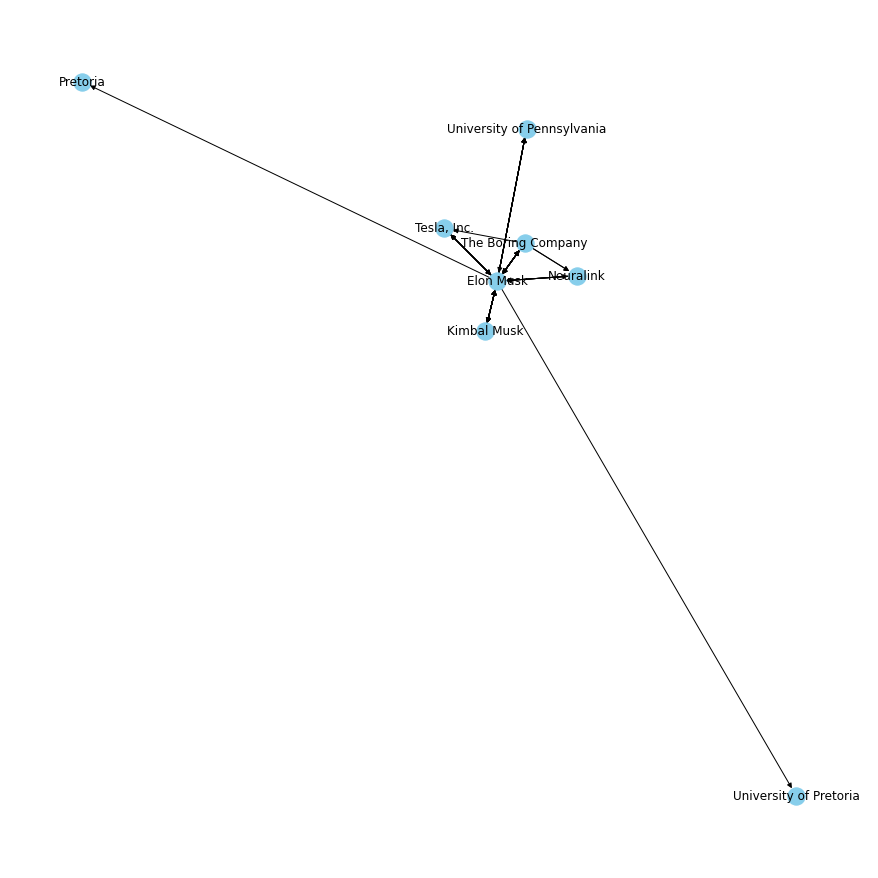

In [29]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

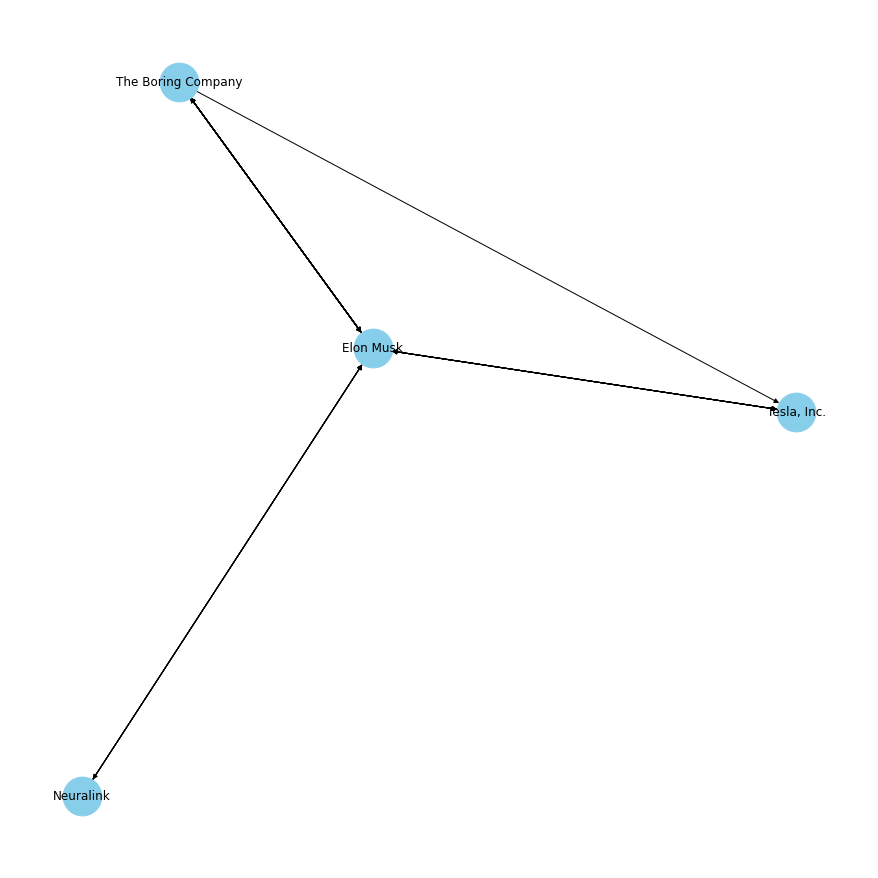

In [36]:
G=nx.from_pandas_edgelist(kg_df[kg_df['type']=="owned by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()